In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset # Network Common Data Form
import sys
import xarray as xr
from datetime import date
from matplotlib import cm
from metpy.plots import ContourPlot, ImagePlot, MapPanel, PanelContainer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import copy

In [2]:
# Import Data in this cell

# Hindcast precipitation
dri  = '/lss/research/agon-lab/CAM_hindcasts/tratl_cam5.3_ne30_rneale.globe/'
fn5  = 'tratl_cam5.3_ne30_rneale.globe.fcast.day05.PRECT.nc'
fn10 = 'tratl_cam5.3_ne30_rneale.globe.fcast.day10.PRECT.nc'
fn15 = 'tratl_cam5.3_ne30_rneale.globe.fcast.day15.PRECT.nc'
fn20 = 'tratl_cam5.3_ne30_rneale.globe.fcast.day20.PRECT.nc'

dataPRECT5  = xr.open_dataset(dri+fn5, decode_times=False)
dataPRECT10 = xr.open_dataset(dri+fn10,decode_times=False)
dataPRECT15 = xr.open_dataset(dri+fn15,decode_times=False)
dataPRECT20 = xr.open_dataset(dri+fn20,decode_times=False)

# Observation precipitation
driObs = '/lss/research/agon-lab/TMPA-daily/'
fnObs  = 'pr_daily_2009-2010.nc'
dataObs = xr.open_dataset(driObs+fnObs,decode_times=False)

# Align obs time stamps with hindcast time stamps: 'days since 2009-09-01 00:00:00'
timeObs = dataObs['time'] - 40055

# Meridional winds
fnVBOT5  = "tratl_cam5.3_ne30_rneale.globe.fcast.day05.VBOT.nc"
fnVBOT10 = "tratl_cam5.3_ne30_rneale.globe.fcast.day10.VBOT.nc"
fnVBOT15 = "tratl_cam5.3_ne30_rneale.globe.fcast.day15.VBOT.nc"
fnVBOT20 = "tratl_cam5.3_ne30_rneale.globe.fcast.day20.VBOT.nc"

dataVBOT5  = xr.open_dataset(dri+fnVBOT5, decode_times=False)
dataVBOT10 = xr.open_dataset(dri+fnVBOT10,decode_times=False)
dataVBOT15 = xr.open_dataset(dri+fnVBOT15,decode_times=False)
dataVBOT20 = xr.open_dataset(dri+fnVBOT20,decode_times=False)

# Zonal winds
fnUBOT5  = "tratl_cam5.3_ne30_rneale.globe.fcast.day05.UBOT.nc"
fnUBOT10 = "tratl_cam5.3_ne30_rneale.globe.fcast.day10.UBOT.nc"
fnUBOT15 = "tratl_cam5.3_ne30_rneale.globe.fcast.day15.UBOT.nc"
fnUBOT20 = "tratl_cam5.3_ne30_rneale.globe.fcast.day20.UBOT.nc"

dataUBOT5  = xr.open_dataset(dri+fnUBOT5, decode_times=False)
dataUBOT10 = xr.open_dataset(dri+fnUBOT10,decode_times=False)
dataUBOT15 = xr.open_dataset(dri+fnUBOT15,decode_times=False)
dataUBOT20 = xr.open_dataset(dri+fnUBOT20,decode_times=False)

In [3]:
# Experiment to open all datasets and place them immediately into one MEGA dataset.
# Objective is to write less code :)

# varName = ['PRECT', 'VBOT', 'UBOT']
# hcastDayStr = ['05', '10', '15', '20']
# hcastDay = [5,10,15,20]
# fn = 'tratl_cam5.3_ne30_rneale.globe.fcast.day'

# _dataRaw = [[0,0,0],[0,0,0],[0,0,0],[0,0,0]] # 4 rows (hindcasts) and 3 columns (variables)

# for ii, day in enumerate(hcastDayStr):
#     for jj, _var in enumerate(varName):
# #         print(dri+fn+day+'.'+name+'.nc')
#         _dataRaw[ii][jj] = xr.open_dataset(dri+fn+day+'.'+_var+'.nc', decode_times=False)
# 
# dataRaw = xr.Dataset({'dataRaw':(['hcastDay', 'varName'], _dataRaw)}, 
#                      coords={'hcastDay':hcastDay, 'varName': varName})
# dataRaw.sel(hcastDay=10,varName='VBOT')['dataRaw']

In [4]:
# ************************************************************************************************
# *************************** USER INPUTS ARE REQUIRED IN THIS CELL ******************************
# ************************************************************************************************


#### Select the date to be analyzed as a value representing the number of days since 2009-09-01 ####
dayOfTheSeason = 140 # For reference: 174 is February 22 and 122 is January 1
#dayOfTheSeason = 'cftime.DatetimeNoLeap(2010-03-02 00:00:00)'

#### Select the number of days to be time averaged ####
numDayAvg = 4

#### Select which day hindcast should be used ####
#DayXXHcast = [5,10,15,20]  # Must be a list of integer(s) from >=1 and <=20

# Choose region of interest 
lats = -20
latn =  20
lonw = -180 # *** For longitudes west of the Prime Meridian, enter a negative number ***
lone = -90  

# ************************************************************************************************

In [5]:
# Time average the 3-hourly wind data to get daily wind data

# Create hindcast day dimension
hcastDay = [5, 10, 15, 20]

# Group together the wind data so it can be iterated
dataVBOT = [ dataVBOT5['V'], dataVBOT10['V'], dataVBOT15['V'], dataVBOT20['V'] ]
dataUBOT = [ dataUBOT5['U'], dataUBOT10['U'], dataUBOT15['U'], dataUBOT20['U'] ]

# Create an array of zeros to hold the daily averaged data
dataVBOTAvg = np.zeros(( 4, len(dataVBOT5['V'])//8 , len(dataVBOT5['V'][0]), len(dataVBOT5['V'][0][0]) ))
dataUBOTAvg = np.zeros(( 4, len(dataVBOT5['V'])//8 , len(dataVBOT5['V'][0]), len(dataVBOT5['V'][0][0]) ))

# Iterate for the number of hindcast days
for ii in range(len(hcastDay)):

    # Iterate for the number of time stamps in 3hrly data. Count by 8
    for jj in range(0, len(dataVBOT5['V']), 8):
        # On the left, jj is divided by 8 so it increases by 1 (each day)
        # On the right, 8 is added to jj to include all 8 daily data points in the mean
        dataVBOTAvg[ii][jj//8] = dataVBOT[ii][jj:jj+8].mean(axis=0)
        dataUBOTAvg[ii][jj//8] = dataUBOT[ii][jj:jj+8].mean(axis=0)

In [6]:
# Create datasets of daily prect, ubot and vbot data for each hindcast day

_dim = ['time', 'lat', 'lon'] # dimensions

data5  = xr.Dataset({'v':(_dim, dataVBOTAvg[0]), 'u':(_dim, dataUBOTAvg[0]), 'prect':(_dim, dataPRECT5['PRECT']*1000*86400)},
                    coords={'time':dataPRECT5['time'] , 'lat' :dataVBOT5['lat' ], 'lon' :dataVBOT5['lon' ]})
data10 = xr.Dataset({'v':(_dim, dataVBOTAvg[1]), 'u':(_dim, dataUBOTAvg[1]), 'prect':(_dim, dataPRECT10['PRECT']*1000*86400)},
                    coords={'time':dataPRECT10['time'], 'lat' :dataVBOT5['lat' ], 'lon' :dataVBOT5['lon' ]})
data15 = xr.Dataset({'v':(_dim, dataVBOTAvg[2]), 'u':(_dim, dataUBOTAvg[2]), 'prect':(_dim, dataPRECT15['PRECT']*1000*86400)},
                    coords={'time':dataPRECT15['time'], 'lat' :dataVBOT5['lat' ], 'lon' :dataVBOT5['lon' ]})
data20 = xr.Dataset({'v':(_dim, dataVBOTAvg[3]), 'u':(_dim, dataUBOTAvg[3]), 'prect':(_dim, dataPRECT20['PRECT']*1000*86400)},
                    coords={'time':dataPRECT20['time'], 'lat' :dataVBOT5['lat' ], 'lon' :dataVBOT5['lon' ]})

In [7]:
# Select the data within the user defined region of interest and combine datasets

# Select data for day 5 to obtain the correct dimensions
#dataSel5 = data5.sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
# Select the data within the Region Of Interest (ROI)
dataROI = [data5.sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360)),
          data10.sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360)),
          data15.sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360)),
          data20.sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))]

In [8]:
# Average the data for the length of the numDayAvg specificed 

dataPlot = [0,0,0,0]

for ii in range( len(dataROI) ):
    dataPlot[ii] = dataROI[ii].mean(dim='time')

In [9]:
# Prepare the raw data so it is ready to be plotted

# Select the precip data
# Subtract 1 from numDayAvg to properly set the stop point of slice. Add 360 to lon to match coordinates of raw data.
precip5  =  dataPRECT5['PRECT'].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), 
                                    lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
precip10 = dataPRECT10['PRECT'].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), 
                                    lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
precip15 = dataPRECT15['PRECT'].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), 
                                    lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
precip20 = dataPRECT20['PRECT'].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), 
                                    lat=slice(lats,latn), lon=slice(lonw+360,lone+360))

# Add 40055 to select the dayOfTheSeason in relation to the obs' time stamps
precipObs = dataObs['pr'].sel(time=slice(dayOfTheSeason+40055, dayOfTheSeason+numDayAvg-1+40055), 
                              lat=slice(lats,latn), lon=slice(lonw,lone))

# Time average (axis=0) the selected precip data and change units from m/s to mm/day
precip_avg5  = np.mean(precip5 *1000*86400, axis=0)
precip_avg10 = np.mean(precip10*1000*86400, axis=0)
precip_avg15 = np.mean(precip15*1000*86400, axis=0)
precip_avg20 = np.mean(precip20*1000*86400, axis=0)

precip_avgObs = precipObs.mean(axis=0)

# Group together precip data for plotting purposes
precip_avg = [0,0,0,0]
precip_avg[0] = precip_avg5
precip_avg[1] = precip_avg10
precip_avg[2] = precip_avg15
precip_avg[3] = precip_avg20

/opt/miniconda3/envs/prod/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/opt/miniconda3/envs/prod/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


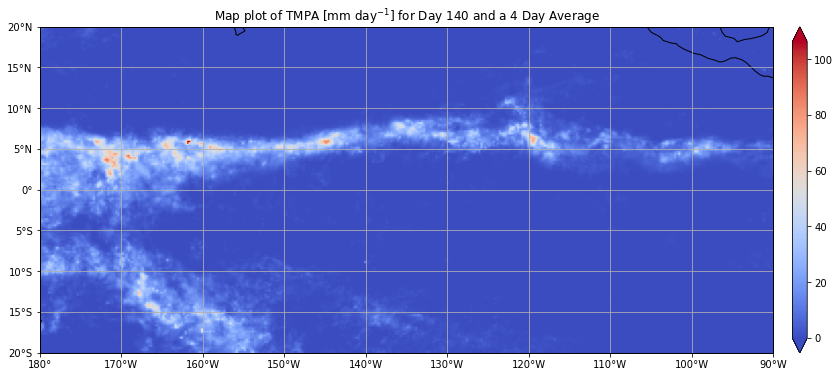

In [10]:
# Create a map plot of the observation data

# Create the figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 6)) 

geo_axes = plt.axes(projection=ccrs.PlateCarree())
geo_axes.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
geo_axes.set_yticks(np.arange(lats,latn+1,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
geo_axes.xaxis.set_major_formatter(lon_formatter)
geo_axes.yaxis.set_major_formatter(lat_formatter)
geo_axes.coastlines()
geo_axes.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5))
image_extent = [lonw,lone,lats,latn]

#a1 = geo_axes.contourf(lon, lat, precip_avg, N, transform=ccrs.PlateCarree(), extend='both',cmap='coolwarm')
IM = geo_axes.imshow(precip_avgObs, extent=image_extent, cmap='coolwarm')

plt.colorbar(IM, ax=geo_axes, orientation='vertical', pad=0.02, extend='both')
plt.title("Map plot of TMPA [mm day$^{-1}$] for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
plt.show()

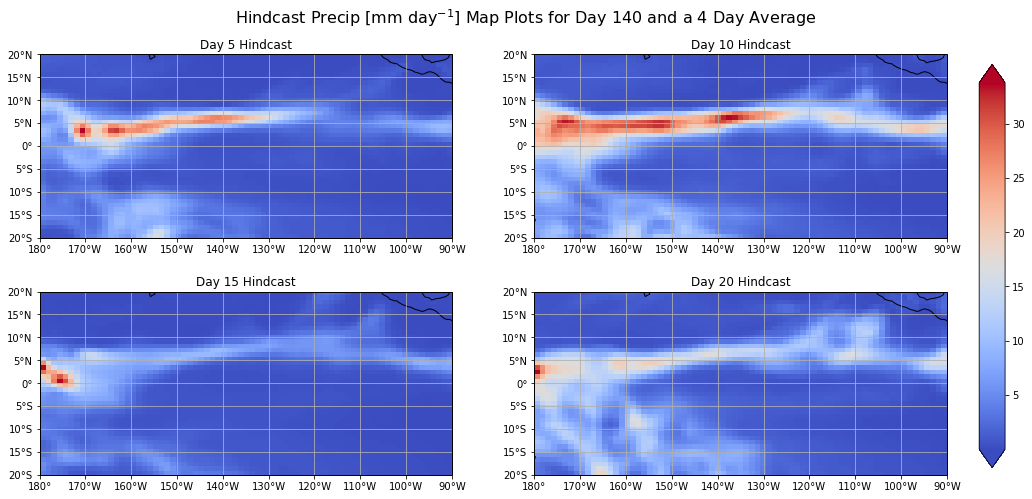

In [11]:
# Plot four subplots for each hindcast day

# Determine the maximum precip value for the colorbar
# mm/day
Vmax = max([precip_avg5.max(),precip_avg10.max(),precip_avg15.max(),precip_avg20.max()])
# mm/hour
# Vmax = max([precip_avg5.max(),precip_avg10.max(),precip_avg15.max(),precip_avg20.max()])/24
# Vmax = 40

# Set border of image
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Iterate through the subplots
counter = 0
for ax in axes.flat:
#     im = ax.imshow(dataPlot['prect'][counter], extent=image_extent, cmap='coolwarm')
    # Plot precip in mm/day
    im = ax.imshow(precip_avg[counter], extent=image_extent, cmap='coolwarm')
    # Plot precip in mm/hour
#     im = ax.imshow(precip_avg[counter]/24, extent=image_extent, cmap='coolwarm', vmin=0, vmax=Vmax)  
    
    # Set asthetic constraints of the plot
    ax.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines()
    ax.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5)) 
    ax.title.set_text('Day '+str((counter+1)*5)+' Hindcast')
        
    counter = counter + 1
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825)
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

fig.suptitle("Hindcast Precip [mm day$^{-1}$] Map Plots for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average",
             size=16,y=0.95)
plt.show()

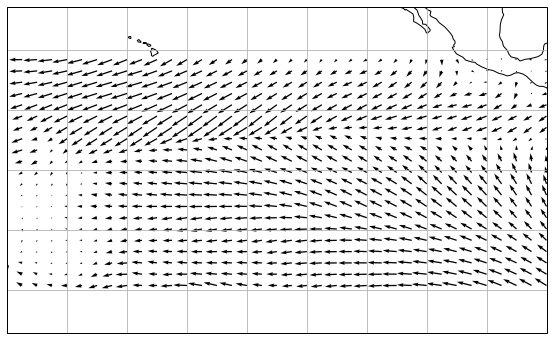

In [80]:
fig = plt.figure(figsize=(17, 6)) 

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.gridlines()
ax.coastlines()
ax.set_extent([lonw,lone,lats,latn])

# Set density of arrows with n. A greater integer reduces the density of arrows
n = int(2)
ax.quiver(dataPlot[0]['lon'][::n],   dataPlot[0]['lat'][::n], 
          dataPlot[0]['u'][::n,::n], dataPlot[0]['v'][::n,::n], transform=ccrs.PlateCarree())

ax.imshow(dataPlot[0]['prect'])


plt.show()
# dataPlot[0]['lon'].values.shape